<a href="https://colab.research.google.com/github/ShivaniMohite1/CODSOFT/blob/main/CODSOFT_ML_Intern_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning Internship :-**

**Task - 1 :- Movie Genre Classification**

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

In [40]:
train_path='/content/train_data.txt'
train_data=pd.read_csv( train_path , sep=':::',engine='python',names=['Title','Genre','Description'])
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [41]:
test_path='/content/test_data.txt'
test_data=pd.read_csv( test_path , sep=':::',engine='python',names=['ID', 'Title','Description'])
test_data.head()

,ID,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


**Data Cleaning**

In [5]:
train_data.describe(include='object').T

,count,unique,top,freq
Title,41710,41710,Oscar et la dame rose (2009),1
Genre,41710,27,drama,10448
Description,41710,41622,Grammy - music award of the American academy ...,10


In [42]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [43]:
train_data.duplicated().sum()

0

In [44]:
train_data.Genre.unique()

array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
       ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
       ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
       ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
       ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
       ' musical ', ' war '], dtype=object)

In [45]:
test_data.describe(include='object').T

,count,unique,top,freq
Title,54200,54200,Edgar's Lunch (1998),1
Description,54200,54072,Grammy - music award of the American academy ...,10


In [46]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54200 non-null  int64 
 1   Title        54200 non-null  object
 2   Description  54200 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [47]:
test_data.duplicated().sum()

0

**Exploratory Data Analysis**

**Text Cleaning**

In [48]:
train_data.loc[train_data['Description'].str.contains(r'@\S+')].head()

,Title,Genre,Description
243,Túlvilági beszélö (1992),documentary,Mail <svaradi@sprynet.com> for translation. T...
1881,Rokonok (1954),drama,Mail <svaradi@sprynet.com> for translation. F...
1987,Lila akác (1934),comedy,Mail <svaradi@sprynet.com> for translation. S...
6580,A csúnya lány (1935),comedy,Mail <svaradi@sprynet.com> for translation. D...
8297,Füszer és csemege (1940),drama,Mail <svaradi@sprynet.com> for translation. 5...


In [49]:
def detect_language(text_data):
    try:
        #Returning the name 'English instide of en'
        return pycountry.languages.get(alpha_2=detect(text)).name.lower()
    except:
        return 'Unknown'
train_data['Language'] = train_data['Description'].apply(detect_language)
test_data['Language'] = test_data['Description'].apply(detect_language)
train_data.head()

,Title,Genre,Description,Language
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,Unknown
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,Unknown
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,Unknown
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,Unknown
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,Unknown


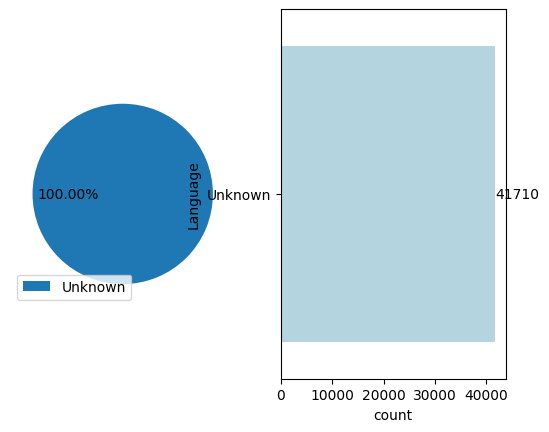

In [17]:
fig,axs = plt.subplots(1,2)
axs[0].pie(train_data.Language.value_counts().values.tolist(),autopct='%.2f%%')
axs[0].legend(labels=train_data.Language.value_counts().index.tolist(),loc='lower left')
sns.countplot(data=train_data,y='Language',order=train_data.Language.value_counts().index.tolist(),ax=axs[1],color='lightblue')
axs[1].bar_label(axs[1].containers[0])
fig.show()

In [50]:
train_data.loc[train_data['Description'].str.contains(r'http\S+')].shape[0]

9

In [51]:
train_data.loc[train_data['Description'].str.contains(r'http\S+')].head()['Description'].iloc[1]


" There's more to the story of the Clintons and 9/11. Over two nights -- September 10-11, 2006, just four months before Hillary announced the exploratory committee for her original presidential campaign, ABC aired The Path to 9/11, a riveting and factual docudrama. This acclaimed and balanced movie faulted two administrations -- Bill Clinton and George W. Bush. But fairness was not what Hillary wanted. Screenwriter Cyrus Nowrasteh told me he had expected the customary DVD distribution. But the Clintons, fearing the impact of DVD release during her campaign, successfully pressured Disney, which owns ABC, to bury the movie. This is a portion of a news article that originally appeared: http://www.frontpagemag.com/fpm/261541/hillarys-path-back-911-arnold-steinberg This article originally appeared in The Huffington Post http://www.huffingtonpost.com/arnold-steinberg/hillarys-path-back-to-911_b_9039658.html This article was written by Arnold Steinberg from Huffington Post and was legally lic

**Cleaning Text Function**

In [52]:
def clean_text(text_data):
    # Remove strange pattern in different languages if exist
    text_data = re.sub('Mail <svaradi@sprynet.com> for translation. ','',text)
    # Remove twitter handles
    text_data = re.sub(r'@\S+', '', text)
    # Remove URLs
    text_data = re.sub(r'http\S+', '', text)
    # Remove punctuations
    text_data = re.sub(f'[{string.punctuation}]','',text)
    # Remove numbers
    text_data = re.sub(f'[{string.digits}]','',text)
    # Remove single charachters
    text_data = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    return text_data

In [54]:
train_data[~train_data.Language.isin(['english'])]

,Title,Genre,Description,Language
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,Unknown
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,Unknown
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,Unknown
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,Unknown
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,Unknown
...,...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...,Unknown
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...,Unknown
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g...",Unknown
54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...,Unknown


In [55]:
#Translate other languages
def trans(text):
    try:
        return Translator().translate(text,dest='en').text
    except:
        return text
train_data.loc[~train_data['Language'].isin(['english']), 'Description']=train_data.loc[~train_data['Language'].isin(['english']),'Description'].apply(trans)
test_data.loc[~test_data['Language'].isin(['english']), 'Description']=test_data.loc[~test_data['Language'].isin(['english']),'Description'].apply(trans)

In [56]:
train_data.drop(columns='Language',inplace=True)
test_data.drop(columns='Language',inplace=True)

<ipython-input-57-3bb4d48b9a34>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['Dest_len'])


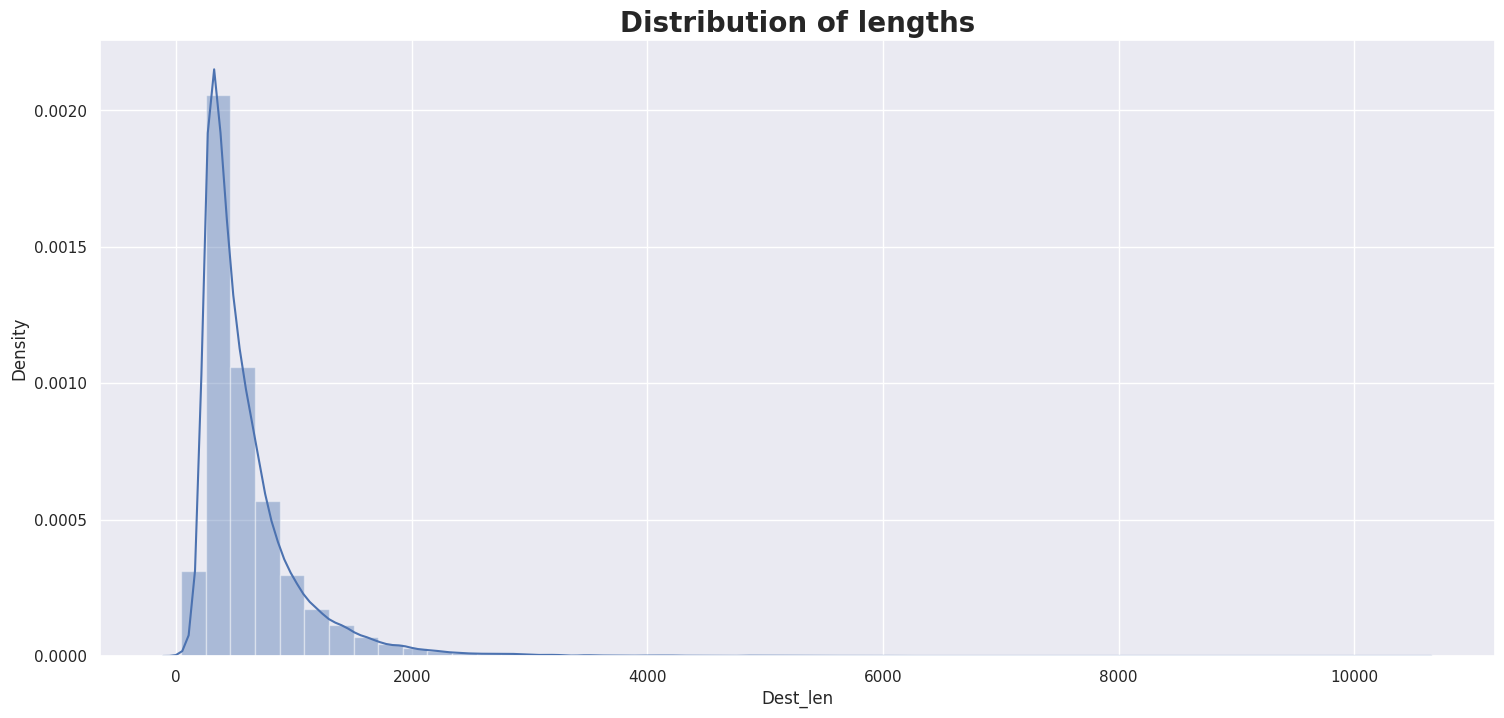

In [57]:
#Distribution of text lengths
train_data['Dest_len'] = train_data['Description'].apply(len)
sns.distplot(train_data['Dest_len'])
plt.title('Distribution of lengths',fontweight='bold',fontsize=20)
plt.show()

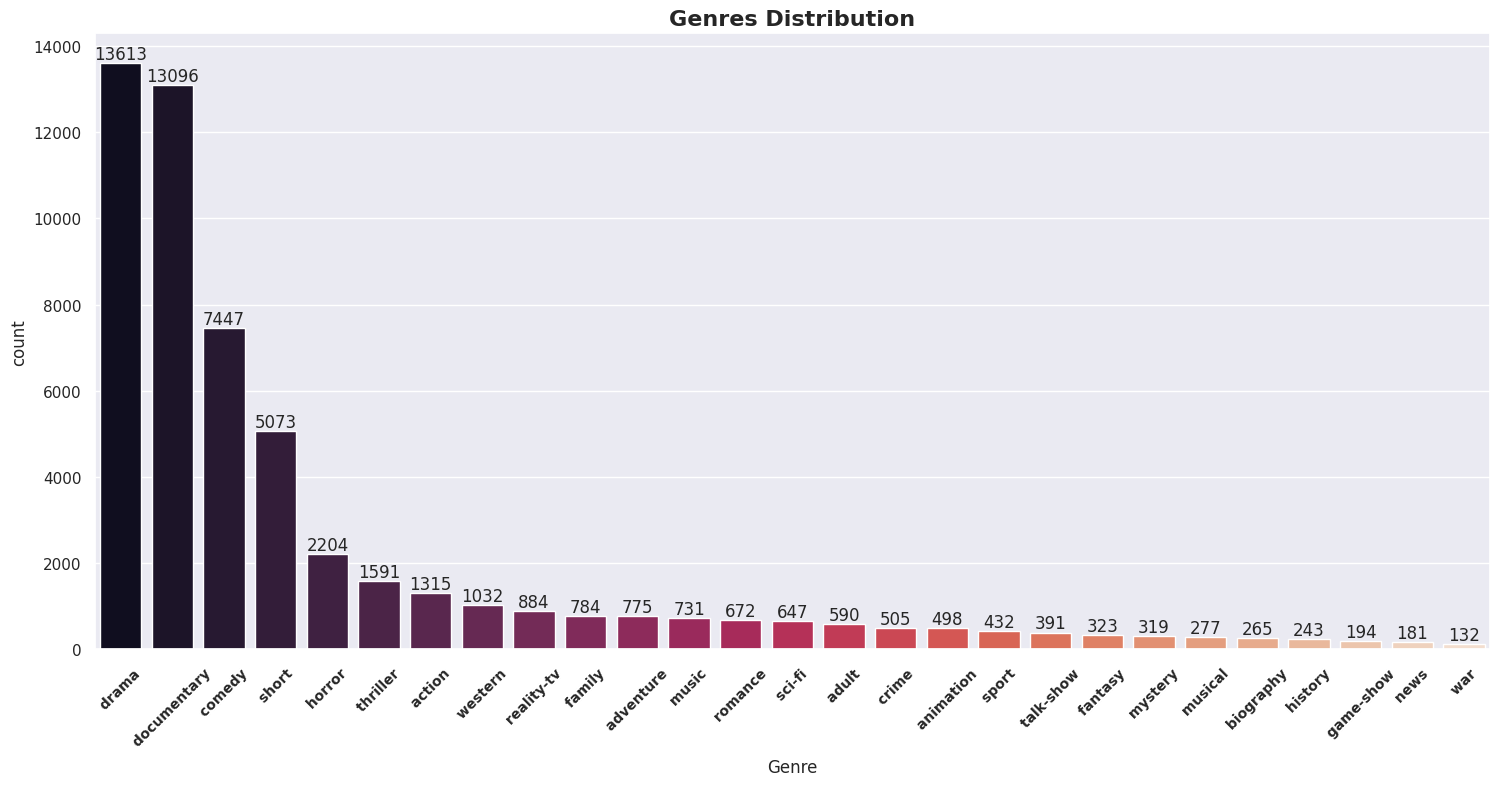

In [58]:
ax=sns.countplot(data=train_data,x='Genre',order=train_data.Genre.value_counts().index,palette='rocket')
ax.bar_label(ax.containers[0])
plt.title('Genres Distribution',fontweight='bold',fontsize=16)
plt.xticks(rotation=45,fontweight='bold',fontsize=10)
plt.show()

**Model Building**

In [59]:
# Using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=True, #Lowercase chars
                                   ngram_range=(1,1), #Capture only single words in each text(unigrams)
                                   stop_words='english',#Remove stop_words
                                   min_df=2)#Ignore words that appears less than 2 times
x_train = tfidf_vectorizer.fit_transform(train_data['Description'])
x_test = tfidf_vectorizer.transform(test_data['Description'])

In [65]:
#We conclude before that drama and documentary have the majority of our data,
#so to avoid imbalance data in our model we will make randomoversampling
#Notice that the accuracy before sampling will be < the accuracy after oversampling
sampler = RandomOverSampler()
#We will pass to it the output of TfidfVectorizer from train data
x_train_data_resampled , y_train_data_resampled = sampler.fit_resample(x_train,train_data['Genre'])

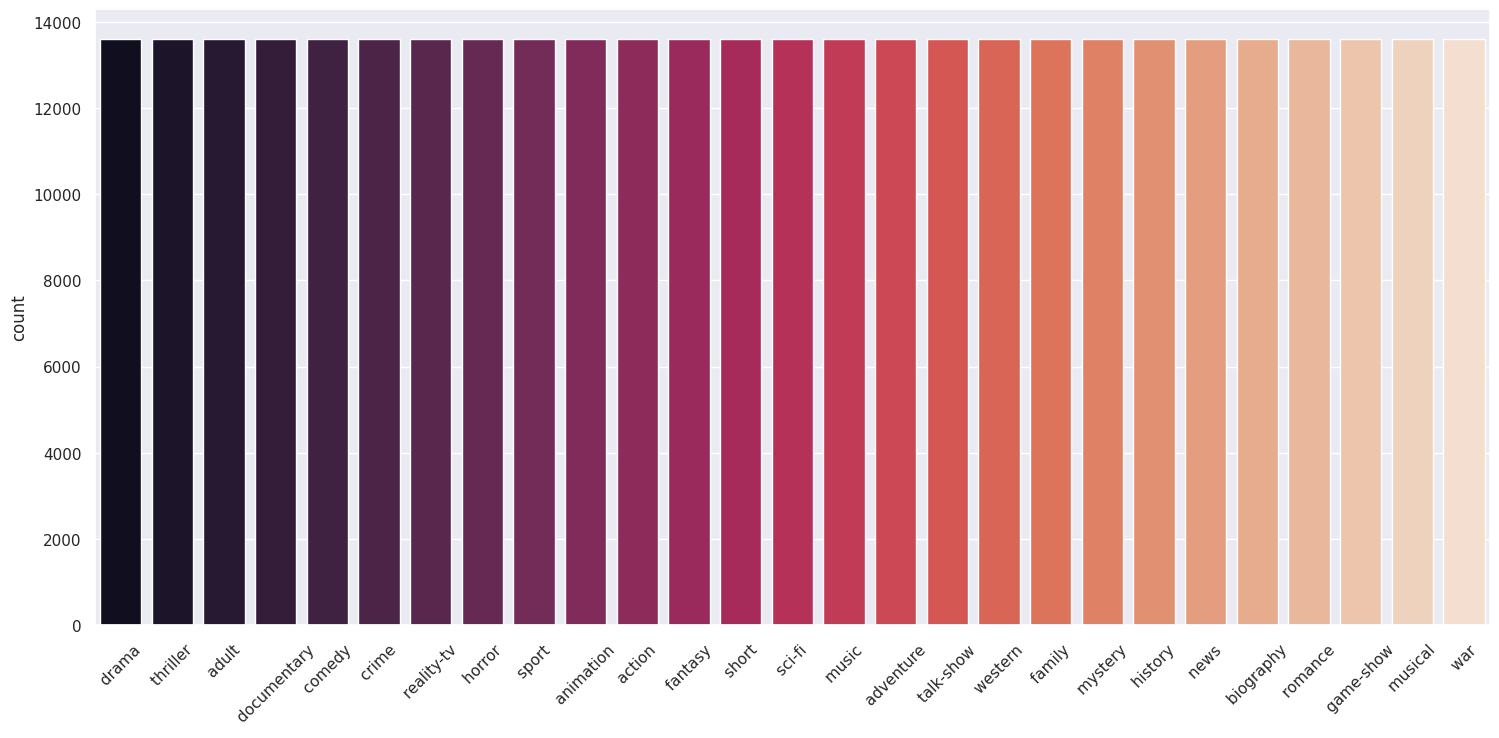

In [66]:
#Let's take a look on genre distribution
sns.countplot(data=y_train_data_resampled,x=y_train_data_resampled.values,palette='rocket')
plt.xticks(rotation=45)
plt.show()

In [67]:
#Double check for length of our data
print('Train_data :',x_train_data_resampled.shape[0])
print('Test_data :',y_train_data_resampled.shape[0])

Train_data : 367551
Test_data : 367551


In [69]:
#Get the actual solutions to compare it with our predictions
y_actual = pd.read_csv(r"/content/test_data_solution.txt",
                      sep=':::',usecols=[2],header=None).rename(columns={2:'Actual_Genre'})
y_actual.head()

,Actual_Genre
0,thriller
1,comedy
2,documentary
3,drama
4,drama


In [70]:
#Naive Bayes Model
NB = MultinomialNB(alpha=0.3)
start_time = time()
NB.fit(x_train_data_resampled,y_train_data_resampled)
y_pred = NB.predict(x_test)
print('Accuracy :',accuracy_score(y_actual,y_pred))
end_time = time()
print('Running Time : ',round(end_time - start_time,2),'Secounds')

Accuracy : 0.5411808118081181
Running Time :  2.15 Secounds


In [71]:
print(classification_report(y_actual,y_pred))

               precision    recall  f1-score   support

      action        0.36      0.48      0.41      1314
       adult        0.50      0.53      0.51       590
   adventure        0.31      0.26      0.28       775
   animation        0.31      0.22      0.26       498
   biography        0.05      0.03      0.04       264
      comedy        0.57      0.53      0.55      7446
       crime        0.17      0.18      0.18       505
 documentary        0.72      0.72      0.72     13096
       drama        0.64      0.56      0.60     13612
      family        0.24      0.21      0.23       783
     fantasy        0.16      0.13      0.15       322
   game-show        0.77      0.66      0.71       193
     history        0.09      0.06      0.07       243
      horror        0.53      0.68      0.59      2204
       music        0.39      0.73      0.51       731
     musical        0.19      0.11      0.14       276
     mystery        0.13      0.08      0.10       318
        n

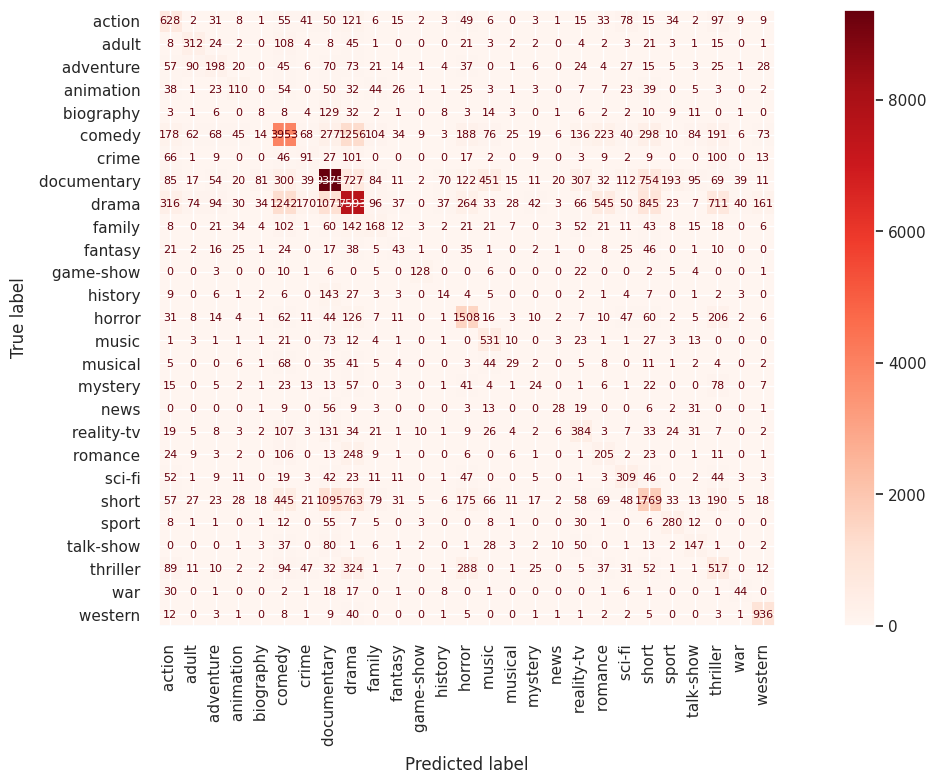

In [72]:
cm =confusion_matrix(y_actual,y_pred,labels=NB.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=NB.classes_)
cmd.plot(cmap=plt.cm.Reds,xticks_rotation='vertical',text_kw={'size': 8})
plt.show()

In [74]:
pd.concat([pd.concat([test_data,y_actual],axis=1),pd.Series(y_pred)],axis=1).rename(columns={0:'Predicted_Genre'}).head(10)

,ID,Title,Description,Actual_Genre,Predicted_Genre
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",thriller,short
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",comedy,drama
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,documentary,documentary
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",drama,drama
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,drama,drama
5,6,Riddle Room (2016),Emily Burns is being held captive in a room w...,horror,thriller
6,7,L'amica (1969),The beautiful but neglected wife of a brillia...,drama,comedy
7,8,Ina Mina Dika (1989),Vasu Inamdar (Ina) suffers from a disorder wh...,comedy,comedy
8,9,Equinox Special: Britain's Tornados (2005),An insight into the tornados that hit Kensal ...,documentary,documentary
9,10,Press (2011),Press is a story of young people overwhelmed ...,drama,short


In [75]:
#We got low accuracy due to insufficient data for other categories
#So the model trained alot about drama and documentary movies so it's hard to discover the others
#Now let's try another approach and see the effect on data
y_train_modified = train_data['Genre'].apply(lambda genre: genre if genre.strip() in ['drama','documentary'] else 'other')
y_actual_modified = y_actual['Actual_Genre'].apply(lambda genre: genre if genre.strip() in ['drama','documentary'] else 'other')

In [77]:
NB = MultinomialNB(alpha=0.3)
start_time = time()
NB.fit(x_train,y_train_modified)
y_pred = NB.predict(x_test)
print('Accuracy :',accuracy_score(y_actual_modified,y_pred))
end_time = time()
print('Running Time : ',round(end_time - start_time,2),'Secounds')

Accuracy : 0.6952583025830258
Running Time :  0.26 Secounds
